@christofhenkel kernel on image feature extraction with pretrained models in Keras (https://www.kaggle.com/christofhenkel/extract-image-features-from-pretrained-nn) inspired me to do the same thing with PyTorch. In this kernel I demonstrate how to extract features with pretrained Inception_v3 model in PyTorch. Previously, @pvlima posted a great kernel on image classification with pretrained models in PyTorch (https://www.kaggle.com/pvlima/use-pretrained-pytorch-models). But, unlike in Keras, pretrained models in PyTorch contain the last FC layer which, in the case of feature extraction, is unnecessary. Also, the trick with Inception_v3 is that it has two outputs: there's an auxiliary branch in the network (https://arxiv.org/abs/1409.4842, https://arxiv.org/abs/1512.00567) which helps with the classification task, but useless for our goal. So, in order to get rid of all unnecessary parts, I inherited Inception_v3 class and overrode the forward method. Also, I added extra 1D average pooling layer to reduce the number of features (originally, it's a 2048D vector). 

In [1]:
import time
import cv2
import numpy as np
import os
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from os.path import isfile, join, abspath, exists, isdir, expanduser
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.models.inception import *
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import lr_scheduler
import torchvision
import random

import matplotlib.pyplot as plt

In [2]:
img_size = 299 # for Incerption V3
BATCH_SIZE = 32
N_EPOCHS = 5

In [3]:
BATCH_SIZE = 32
DATA_PATH = "../299_cropped_bird_dataset"
DATA_TRANSFORMS = transforms.Compose(
    [
        transforms.transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
EMBEDDINGS_PATH = "../Inceptionv3_embeddings"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

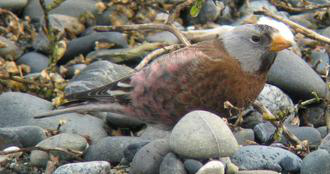

In [4]:
filename = "../cropped_bird_dataset/train_images/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0064_27007.jpg"
input_image = Image.open(filename)
input_image

In [5]:
# pre-processing required by ResNext
preprocess = transforms.Compose([
    #transforms.Resize((299,299)),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


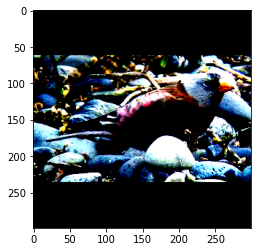

In [6]:
# Plotting the preprocessed picture to be usable by the model
# the range of values now fall outside the [0..1] RGB valid range
plt.imshow(np.moveaxis(input_tensor.numpy(), 0, -1 ))
plt.show()

In [7]:
class CustomInception3(Inception3):
    def __init__(self, num_classes=1000, aux_logits=False, transform_input=False, final_pooling=None):
        self.final_pooling = final_pooling
        super(CustomInception3, self).__init__()
        
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        # 299 x 299 x 3
        x = self.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x)
        # 71 x 71 x 192
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 35 x 35 x 192
        x = self.Mixed_5b(x)
        # 35 x 35 x 256
        x = self.Mixed_5c(x)
        # 35 x 35 x 288
        x = self.Mixed_5d(x)
        # 35 x 35 x 288
        x = self.Mixed_6a(x)
        # 17 x 17 x 768
        x = self.Mixed_6b(x)
        # 17 x 17 x 768
        x = self.Mixed_6c(x)
        # 17 x 17 x 768
        x = self.Mixed_6d(x)
        # 17 x 17 x 768
        x = self.Mixed_6e(x)
        # 17 x 17 x 768
        
        ## we turn off auxiliary
        #if self.training and self.aux_logits:
        #    aux = self.AuxLogits(x)
        
        # 17 x 17 x 768
        x = self.Mixed_7a(x)
        # 8 x 8 x 1280
        x = self.Mixed_7b(x)
        # 8 x 8 x 2048
        x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8) # size (batch_size, 2048, 1, 1)
        # 1 x 1 x 2048
        
        ## We'll save average pooling over the last conv output, but turn off the last FC layer
       
        #x = F.dropout(x, training=self.training)
        # 1 x 1 x 2048
        #x = x.view(x.size(0), -1)
        # 2048
        #x = self.fc(x)
        
        ## turn off aux output
        # 1000 (num_classes)
        #if self.training and self.aux_logits:
        #    return x, aux
        
        if self.final_pooling:
            x = F.avg_pool1d(x.view(x.size(0), 2048, 1).permute(0, 2, 1), kernel_size=self.final_pooling)
        
        return x

### Create Custom Inception instance and load weights

In [15]:
inception_weights = "/Users/chloesekkat/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth"

We apply an extra 1D average pooling to the final 1 x 1 x 2048 activations. <br>
Here we use kernel of size 8, so the final output will have 256 features.

In [21]:
InceptionModel = CustomInception3(final_pooling=1)
InceptionModel.load_state_dict(torch.load(inception_weights))
InceptionModel.eval()

CustomInception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3)

In [24]:
input_batch = torch.stack([input_tensor])
input_batch = input_batch.to(device)

# applying the model to the pre-processed picture and extracting the 2048 ResNext features
with torch.no_grad():
    output = InceptionModel(input_batch).flatten(start_dim=1)
print('shape', output.shape)

shape torch.Size([1, 2048])


### Extract features with CustomInception and concat them to the original dataframe

In [ ]:
def extract_features(df, image_folder, model):
    model.eval() 
    model = model.cuda()
    img_ids = find_ids_w_images(df, image_folder)
    
    data_ds = ImageLoader(img_ids, dir_name=image_folder, transform=ds_trans)
    data_dl = DataLoader(data_ds, batch_size=BATCH_SIZE, shuffle=False)
    
    with torch.no_grad():
        features = None
        for x in tqdm(data_dl, disable=True):
            x = x.cuda()
            output = model(x)

            if features is not None:
                features = torch.cat((features, output), 0)
            else:
                features = output
        
        features = features.view(features.size(0), -1)
        feat_df = pd.DataFrame(features.cpu().numpy(), columns=[f'img_{n}' for n in range(features.size(-1))])
        feat_df = pd.concat((pd.DataFrame({'PetID': img_ids}), feat_df), axis=1)
        
        feat_df = df.merge(feat_df, on='PetID', how='outer')
        
        feat_df = feat_df.fillna(0)
    
    return feat_df

In [ ]:
train_df = extract_features(train_df, train_path, InceptionModel)

In [ ]:
test_df = extract_features(train_df, train_path, InceptionModel)